# 2

In [3]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy.linalg as SLA

In [71]:
N = 50

def gen_x(n):
    '''return a list of x'''
    return np.array([i/(n-1) for i in range(n)])

def gen_f(x):
    '''return a list of f(x)'''
    ff = []
    for xx in x:
        tmp = 0
        for k in range(4):
            if xx >= (k+1)/5:
                 tmp += 10
        ff.append(tmp) 
    return np.array(ff)

def gen_y(n,f):
    '''return a list of y'''
    yy = np.zeros(n)
    for i in range(n):
        if i == 24:
            yy[i] = 0
        else:
            yy[i] = f[i] + np.random.randn()
    return yy

def kernel_rbf(x, z, gamma):
    '''return the kernel matrix between x and z''' 
    return np.exp(-gamma*(x-z)*(x-z))

def ls_obj_fn(alpha, k, y, lamb):
    '''return least square objective function'''
    return cp.pnorm(k@alpha - y, p=2)**2 + \
            lamb*cp.pnorm(alpha.T@np.real(SLA.sqrtm(k)), p=2)**2

def huber_obj_fn(alpha, k, y, lamb):
    '''return huber objective function'''
    return cp.sum(cp.huber(k@alpha - y)) + \
            lamb*cp.pnorm(alpha.T@np.real(SLA.sqrtm(k)), p=2)**2

def D(n):
    '''return D matrix'''
    tv = 0
    mat = np.zeros((n-1, n))
    for i in range(n-1):
        mat[i,i] = -1
        mat[i,i+1] = 1
    return mat

def tv_obj_fn(alpha, k, y, lamb1, lamb2):
    '''return the objective function including a TV term'''
    return cp.pnorm(k@alpha - y, p=2)**2 + \
            lamb1*cp.pnorm(D(len(k))@k@alpha, p=1) + \
            lamb2*cp.pnorm(alpha.T@np.real(SLA.sqrtm(k)), p=2)**2

def cvx_optmz(x, y, k, loss_fn, lamb=None, lamb1=None, lamb2=None):
    '''do cvxpy optimization and return obtained alpha'''
    alpha = cp.Variable(len(x))
    if loss_fn == 'ls' or loss_fn == 'constr':
        objective = cp.Minimize(ls_obj_fn(alpha, k, y, lamb))
    elif loss_fn == 'huber':
        objective = cp.Minimize(huber_obj_fn(alpha, k, y, lamb))
    elif loss_fn == 'tv':
        objective = cp.Minimize(tv_obj_fn(alpha, k, y, lamb1, lamb2))
    if loss_fn != 'constr':
        prob = cp.Problem(objective)
    else:
        constrains = [D(len(k))@k@alpha >= 0]
        prob = cp.Problem(objective, constrains)
    prob.solve()
    return alpha.value

def bootstrap(X, Y, loss_fn):
    '''return best lambda and gamma'''
    
    obj_list = []
    lamb_list = []
    gamma_list = []
    for gamma in np.arange(33.0, 40.0, 2.0):
        lamb = 1.0
        while lamb > 1e-4:
            obj = 0
            for i in range(N):  
                # extract training data and validation data
                X_tr = np.append(X[0:i], X[i+1:N])
                Y_tr = np.append(Y[0:i], Y[i+1:N])
                X_va = X[i]
                Y_va = Y[i]
                # calculate kernel matrix for training and CV
                K = kernel_rbf(X_tr[:,np.newaxis],X_tr[np.newaxis,:], gamma)
                K_va = np.exp(-gamma*(X_va-X_tr[np.newaxis,:])**2)
                # get alpha from cvx optimization
                alpha = cvx_optmz(X_tr, Y_tr, K, loss_fn, lamb)
                # calculate the loss
                if loss_fn == 'ls' or loss_fn == 'constr':
                    obj += (cp.pnorm(K_va@alpha - Y_va, p=2)**2).value
                elif loss_fn == 'huber':
                    obj += (cp.sum(cp.huber(K_va@alpha - Y_va))).value
            # store the results for each lambda in one list
            obj_list.append(obj)
            lamb_list.append(lamb) 
            gamma_list.append(gamma)
            lamb /= 2 
    # pick the lamb that makes the total loss least
    lamb_best = lamb_list[obj_list.index(np.min(obj_list))]
    gamma_best = gamma_list[obj_list.index(np.min(obj_list))] 
    return lamb_best, gamma_best

def bootstrap_tv(X, Y, loss_fn):
    '''return the best lamb1, lamb2 and gamma'''
    
    obj_list = []
    lamb1_list = []
    lamb2_list = []
    gamma_list = []
    for gamma in np.arange(33.0, 40.0, 2.0):
        lamb1 = 6.0
        while lamb1 > 1:
            lamb2 = 1.0
            while lamb2 > 1e-2:
                obj = 0
                for i in range(N):  
                    # extract training data and validation data
                    X_tr = np.append(X[0:i], X[i+1:N])
                    Y_tr = np.append(Y[0:i], Y[i+1:N])
                    X_va = X[i]
                    Y_va = Y[i]
                    # calculate kernel matrix for training and CV
                    K = kernel_rbf(X_tr[:,np.newaxis],X_tr[np.newaxis,:], gamma)
                    K_va = np.exp(-gamma*(X_va-X_tr[np.newaxis,:])**2)
                    # get alpha from cvx optimization
                    alpha = cvx_optmz(X_tr, Y_tr, K, loss_fn, lamb1=lamb1, lamb2=lamb2)
                    # calculate the loss
                    if loss_fn == 'tv':
                        obj += (cp.pnorm(K_va@alpha - Y_va, p=2)**2).value

            # store the results for each lambda in one list
                obj_list.append(obj)
                lamb1_list.append(lamb1) 
                lamb2_list.append(lamb2)
                gamma_list.append(gamma)
                lamb2 /= 2 
            lamb1 /= 1.2
    # pick the lamb that makes the total loss least
    lamb1_best = lamb1_list[obj_list.index(np.min(obj_list))]
    lamb2_best = lamb2_list[obj_list.index(np.min(obj_list))]
    gamma_best = gamma_list[obj_list.index(np.min(obj_list))]
    return lamb1_best, lamb2_best, gamma_best

def fn_rbf(X, Y, loss_fn):
    '''return rbf f(x)'''
    #gamma = cal_gamma(X[:,np.newaxis], X[np.newaxis,:])
    
    f_list = []
    if loss_fn != 'tv':
        lamb, gamma = bootstrap(X,Y,loss_fn)
        print(gamma)
        k = kernel_rbf(X[:,np.newaxis],X[np.newaxis,:], gamma)
        alpha = np.array(cvx_optmz(X, Y, k, loss_fn, lamb)).reshape((1,N))
    else:
        lamb1, lamb2, gamma = bootstrap_tv(X,Y,loss_fn)
        k = kernel_rbf(X[:,np.newaxis],X[np.newaxis,:], gamma)
        alpha = np.array(cvx_optmz(X, Y, k, loss_fn, lamb1=lamb1, lamb2=lamb2)).reshape((1,N))
        
    for x in X:
        f_list.append(np.sum(alpha * kernel_rbf(x, X, gamma)))
    return np.array(f_list)

def plot_2(x, y, f, ff):
    '''plot of problem 2.a'''
    plt.figure()
    plt.plot(x, y, 'ro', label = 'original data')
    plt.plot(x, f, 'b-', label = 'true f(x)')
    plt.plot(x, ff, 'g-', label = 'rbf f(x)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

In [35]:
X = gen_x(N)
F = gen_f(X)
Y = gen_y(N,F)

## 2.a

39.0


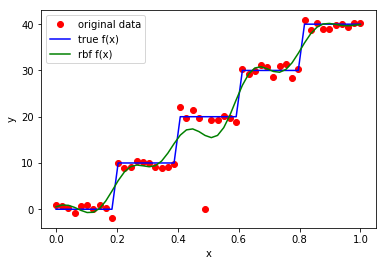

In [65]:
Fls = fn_rbf(X, Y, 'ls')     
plot_2(X,Y,F,Fls)

## 2.b

36.0


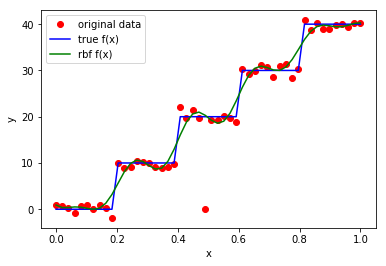

In [66]:
Fhuber = fn_rbf(X, Y, 'huber') 
plot_2(X,Y,F,Fhuber)

## 2.c

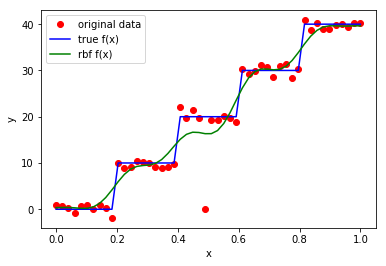

In [68]:
Ftv = fn_rbf(X, Y, 'tv') 
plot_2(X,Y,F,Ftv)

## 2.d

39.0


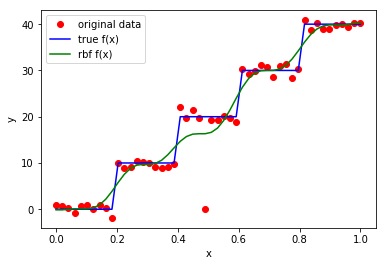

In [69]:
Fconstr = fn_rbf(X, Y, 'constr') 
plot_2(X,Y,F,Fconstr)

# 3